* I will import the following libraries for the project:

In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from IPython.display import Image
from IPython.core.display import HTML 

DO = '#7D1B7E' #for color

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

## Data Import
* All data is open sourced, and more information can be found here:
[AirlineFleet Data](https://www.kaggle.com/traceyvanp/airlinefleet)
* This dataset consists of 11 columns with 1,583 rows

In [407]:
df = pd.read_csv('./data/fleet_visualization_data_analyst.csv')
print(df.shape)
df.head()

(1583, 11)


,Parent Airline,Airline,Aircraft Type,Current,Future,Historic,Total,Orders,Unit Cost,Total Cost (Current),Average Age
0,Aegean Airlines,Aegean Airlines,Airbus A319,1.0,NaN,3.0,4.0,NaN,$90,$90,11.6
1,Aegean Airlines,Olympic Air,Airbus A319,NaN,NaN,8.0,8.0,NaN,$90,$0,NaN
2,Aegean Airlines,Aegean Airlines,Airbus A320,38.0,NaN,3.0,41.0,NaN,$98,"$3,724",7.5
3,Aegean Airlines,Olympic Air,Airbus A320,NaN,NaN,9.0,9.0,NaN,$98,$0,NaN
4,Aegean Airlines,Aegean Airlines,Airbus A321,8.0,NaN,NaN,8.0,NaN,$115,$919,10.3


## Data Cleaning

* For the sake of simplicity and efficiency, I will change the columns names to all lower-case and also replace the spaces to underscores.

In [408]:
df.columns = [column.lower().replace(' ', '_') for column in df.columns]
df.rename(columns={'total_cost_(current)': 'current_total_cost'}, inplace=True)

* Before I proceed further in the data analysis and visualization, I want to check if there are any null/missing values in the dataset. 
* The columns listed below are all the features that contain null-values. The bar-chart further below represents a graph that visually displays the amount of null-values for each columns.

In [409]:
df.isnull().sum()

parent_airline           0
airline                  0
aircraft_type            0
current                724
future                1395
historic               470
total                   99
orders                1235
unit_cost               35
current_total_cost      27
average_age            763
dtype: int64

(1583, 11)


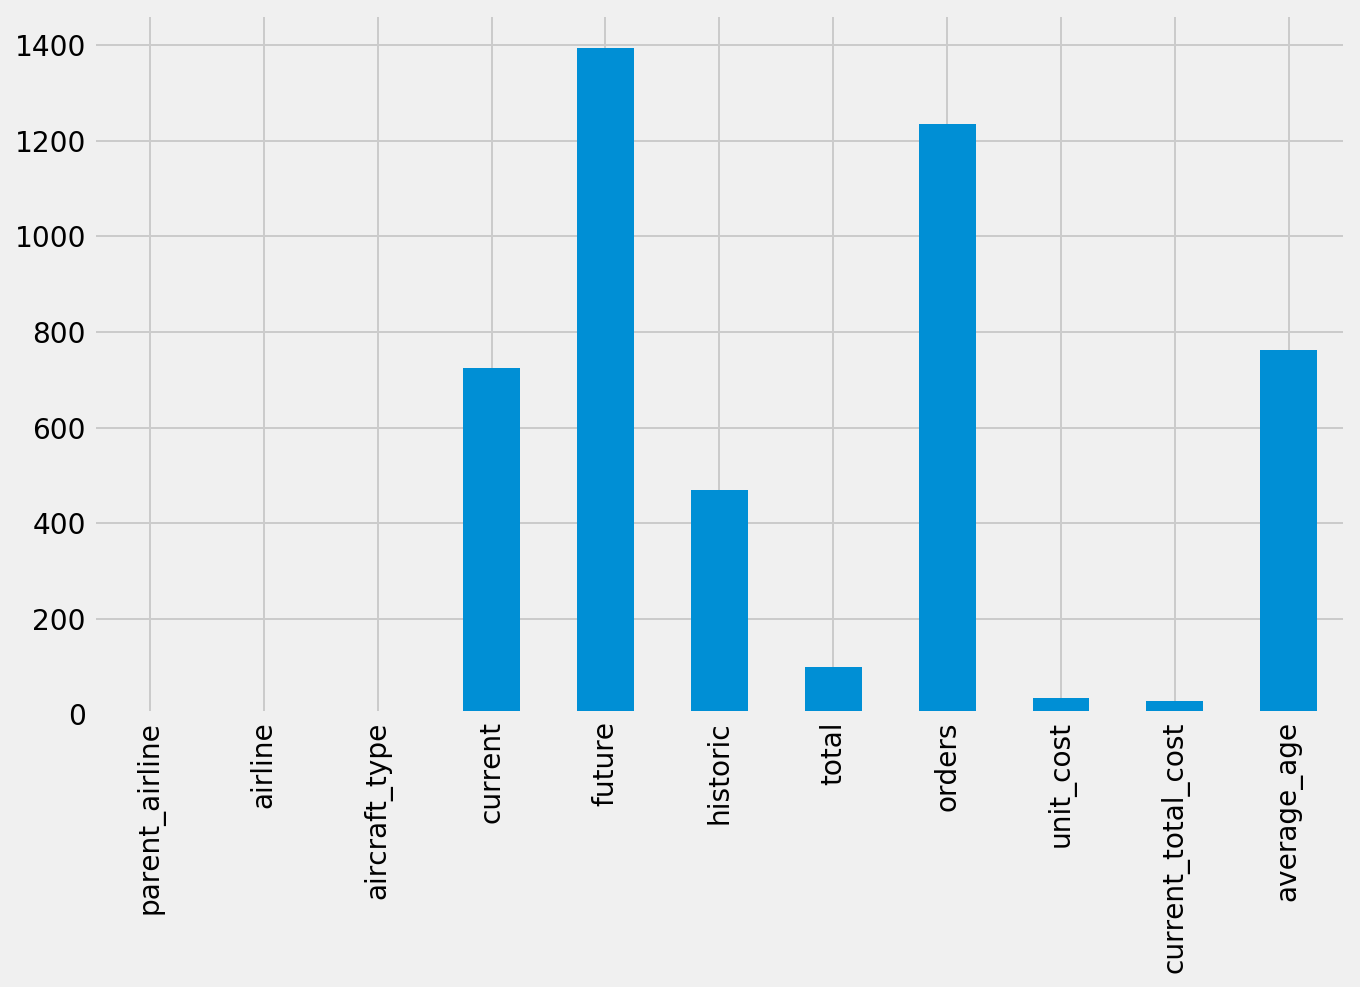

In [410]:
print(df.shape)
df.isnull().sum().plot('bar', figsize=(10,6));

Not only are there huge sum of null-values across many of the columns, but certain features ('future' and 'orders') have signficant missing values. In the case of column 'future', over 88% of its' values are null. I will go through each of the features that have null-values and determine what the best course of action will be. For information on the features and what it represents, I looked to [AirlineFleet Data](https://www.kaggle.com/traceyvanp/airlinefleet). 

**current:** Quantity of airplanes in Operation
* Based on this description, I will assume that the missing values are due to the airlines not having any airplanes in operation. I will replace all the null-values to zero.

**future:** Quantity of airplanes on order, from planespotter.net
* I will remove this column as +88% of its values are null. This column provides no significant information.

**historic:** *Quantity of airplanes in operation in the past?* (guess as it is not provided)
* I will assume the missing values are due to the airlines not having any airplanes in the past. I will replace all the null-values to zero.

**total:** *Quantity of total airplanes in operation from historic to current?* (guess as it is not provided)
* I will assume 'current' plus 'historic' airlines equal to the 'total'. If both current and historic are zero, total will also be changed to zero.

**orders:** Quantity of airplanes on order, from Wikipedia
* I will assume that the missing values are due to the zero number of airplanes on order. I will replace all null-values to zero.

**unit_cost:** Average unit cost of Aircraft Type
* Since the missing values of the 'unit_cost' column is only 35. I will remove the rows associated with such values as it provides no signficant information.

**current_total_cost:** Current quantity times Unit Cost
* I will account for the current total cost estimates based on whether the current quantity and unit cost values exist. For the rest of the missing values, I will remove those as well. (I predict these rows will already be removed when I remove the unit_cost missing rows)

**average_age:** Average age of "Current airplanes by "Aircraft Type"
* Since the average age of planes  cannot be zero just because there is no current airplanes in operation. I will replace the missing values with the "average age" of current airplanes by the aircraft types according to this dataset.

In [411]:
df['current'].fillna('0', inplace=True)
df.drop('future',1,inplace=True)
df['historic'].fillna('0', inplace=True)
df['orders'].fillna('0', inplace=True)
df.dropna(subset=['unit_cost'], inplace=True)
df.dropna(subset=['current_total_cost'], inplace=True)


In [412]:
total_nulls = df[df['total'].isnull()]
# I created a separate dataframe consisting of all the values for the null rows in the 'total' column. 

# Using this mask, I added the values in the 'current' and 'historic' columns to get the 'total' values. 
total_nulls['current'] = total_nulls['current'].astype('int')
total_nulls['historic'] = total_nulls['historic'].astype('int')

total_nulls['total'] = total_nulls['current'] + total_nulls['historic']

# I replaced the missing values in the 'total' column to the new values from above.
df['total'][df['total'].isnull()] = total_nulls['total']

/Users/jameslee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/jameslee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jameslee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

* After removing/adjusting the missing or null values in the dataset, I only have the null-values of the average_age column left. I plan to leave this as it is for now. 

In [413]:
df.isnull().sum()

parent_airline          0
airline                 0
aircraft_type           0
current                 0
historic                0
total                   0
orders                  0
unit_cost               0
current_total_cost      0
average_age           738
dtype: int64

* Now that the dataset is cleaner, I will move onto the exploratory data analysis portion.
* I will save the clean dataset onto the 'data' folder to resume where I left off. 

In [414]:
df.shape

(1547, 10)

In [415]:
df.to_csv('./data/fleet_clean.csv', index=None)

# Please go to worksheet titled: 02_EDA